## Q1
   **Some variants in 23andMe files don’t have an rsID, why might this be the case?**
   > Some variants do not have an rsID because they may be either **novel variants** and or **have not been assigned** in the [dbSNP database](https://customercare.23andme.com/hc/en-us/articles/212196908-What-Are-RS-Numbers-Rsid) as mentioned on the 23andMe support page.
---

## Q2
   **Write a python script that compares the similarity of two individuals given the genotypes in their 23andMe files, based on Identity By State (IBS). The program should take in two 23andMe files and calculate by comparing the genotypes in both files. There are three possible scores at each locus: 0 for no shared alleles, 1 for one shared allele, 2 for both alleles shared. Add the similarity scores for each locus and divide by the maximum possible score to get the average. Only consider the autosomal chromosomes (not the X or Y chromosomes or the mitochondrial SNPs).**

   **Your program should handle the following cases:**
   * If the individuals were genotyped with different versions of the 23andMe SNP chip, there will be SNPs present in one individual's file that are absent in the other. Your program will skip any SNPs that are not in both files.
   * There may be SNPs where the genotype is not called (or only partially called). Your program will skip any SNPs that are not called for both alleles in both files.

---

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

In [2]:
# get files (individual names) stored in txt_files

root_dir = Path("txt_files")
txt_files = {i.stem.split("_")[0]: i for i in root_dir.glob("*.txt")}
names = list(txt_files)
print(names)

['Cristelle', 'Lisa', 'Kate', 'Rachel', 'Oliver', 'Terion', 'Steve']


In [3]:
# parsing 23andMe txt files for autosomal chromosomes only
# excluding comment/header; X,Y, mt chromosomes; missing or incomplete calls; non-nitrogenous bases

def file_parsing(files):
    genotypes = {}
    autosomal = {str(c) for c in range(1, 23)}
    with open(files, "r", encoding="utf-8", errors="replace") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split("\t")
            if len(parts) < 4:
                continue
            rsid, chromosome, genotype = parts[0], parts[1], parts[3]
            if chromosome not in autosomal or len(genotype) != 2 or not all(c in "ACGT" for c in genotype):
                continue
            genotypes[rsid] = genotype
    return genotypes

In [4]:
# ibs score calculation (0, 1, or 2) for 2 diploid genotypes
def ibs(genotype_1, genotype_2):
    common = Counter(genotype_1) & Counter(genotype_2)
    return sum(common.values())

In [5]:
# compare shared rsIDs between 2 individuals
def shared_rsids(file_1, file_2):
    gen_1 = file_parsing(file_1)
    gen_2 = file_parsing(file_2)
    common_rsids = set(gen_1.keys()) & set(gen_2.keys())  # get shared SNPs
    if not common_rsids:
        return None  # for not compatible chips to not divide by 0
    total_ibs = sum(ibs(gen_1[rsid], gen_2[rsid]) for rsid in common_rsids)
    max_ibs = len(common_rsids) * 2
    return total_ibs / max_ibs

## Q3
**Run your program to compute the IBS between each pair of individuals. As a sanity check, run your program also to compute the IBS between each individual and his/herself. If the self-similarity is not equal to 1, your program is not working correctly. What is the IBS between each of the 21 pairs?**

---

In [6]:
# sanity check for 7 individuals
# get IBS between each of the 21 pairs

n = len(names)
ibs_matrix = np.zeros((n, n)) # 7x7 matrix

for i in range(n):
    for j in range(i, n): # symmetric matrix: j at i
        score = shared_rsids(txt_files[names[i]], txt_files[names[j]])
        ibs_matrix[i, j] = score
        ibs_matrix[j, i] = score

ibs_df = pd.DataFrame(ibs_matrix, index=names, columns=names).round(4)
display(ibs_df)

,Cristelle,Lisa,Kate,Rachel,Oliver,Terion,Steve
Cristelle,1.0000,0.8578,0.8596,0.7427,0.8570,0.7477,0.7297
Lisa,0.8578,1.0000,0.8590,0.7449,0.8583,0.7450,0.7330
Kate,0.8596,0.8590,1.0000,0.7422,0.8578,0.7489,0.7307
Rachel,0.7427,0.7449,0.7422,1.0000,0.7442,0.7640,0.7469
Oliver,0.8570,0.8583,0.8578,0.7442,1.0000,0.7426,0.7305
Terion,0.7477,0.7450,0.7489,0.7640,0.7426,1.0000,0.7430
Steve,0.7297,0.7330,0.7307,0.7469,0.7305,0.7430,1.0000


## Q4
**Make a hierarchical clustering dendrogram for the seven individuals based on IBS similarity scores. You will have to convert the IBS similarity matrix into a distance matrix by subtracting the IBS scores from one (so the most similar genotypes are “closest” to each other with small scores). In Python, these modules will provide everything you need: numpy, scipy.cluster.hierarchy (dendrogram and linkage) and matplotlib.pyplot. For the linkage function, use the 'ward' method, and 'euclidean' metric.**

---

In [7]:
# hierarchical clustering dendrogram
# convert IBS similarity matrix to distance matrix: distance = 1 - IBS

distance_matrix = 1 - ibs_matrix
condense = squareform(distance_matrix) # linkage needs condensed 1D array
link = linkage(condense, method="ward", metric="euclidean")


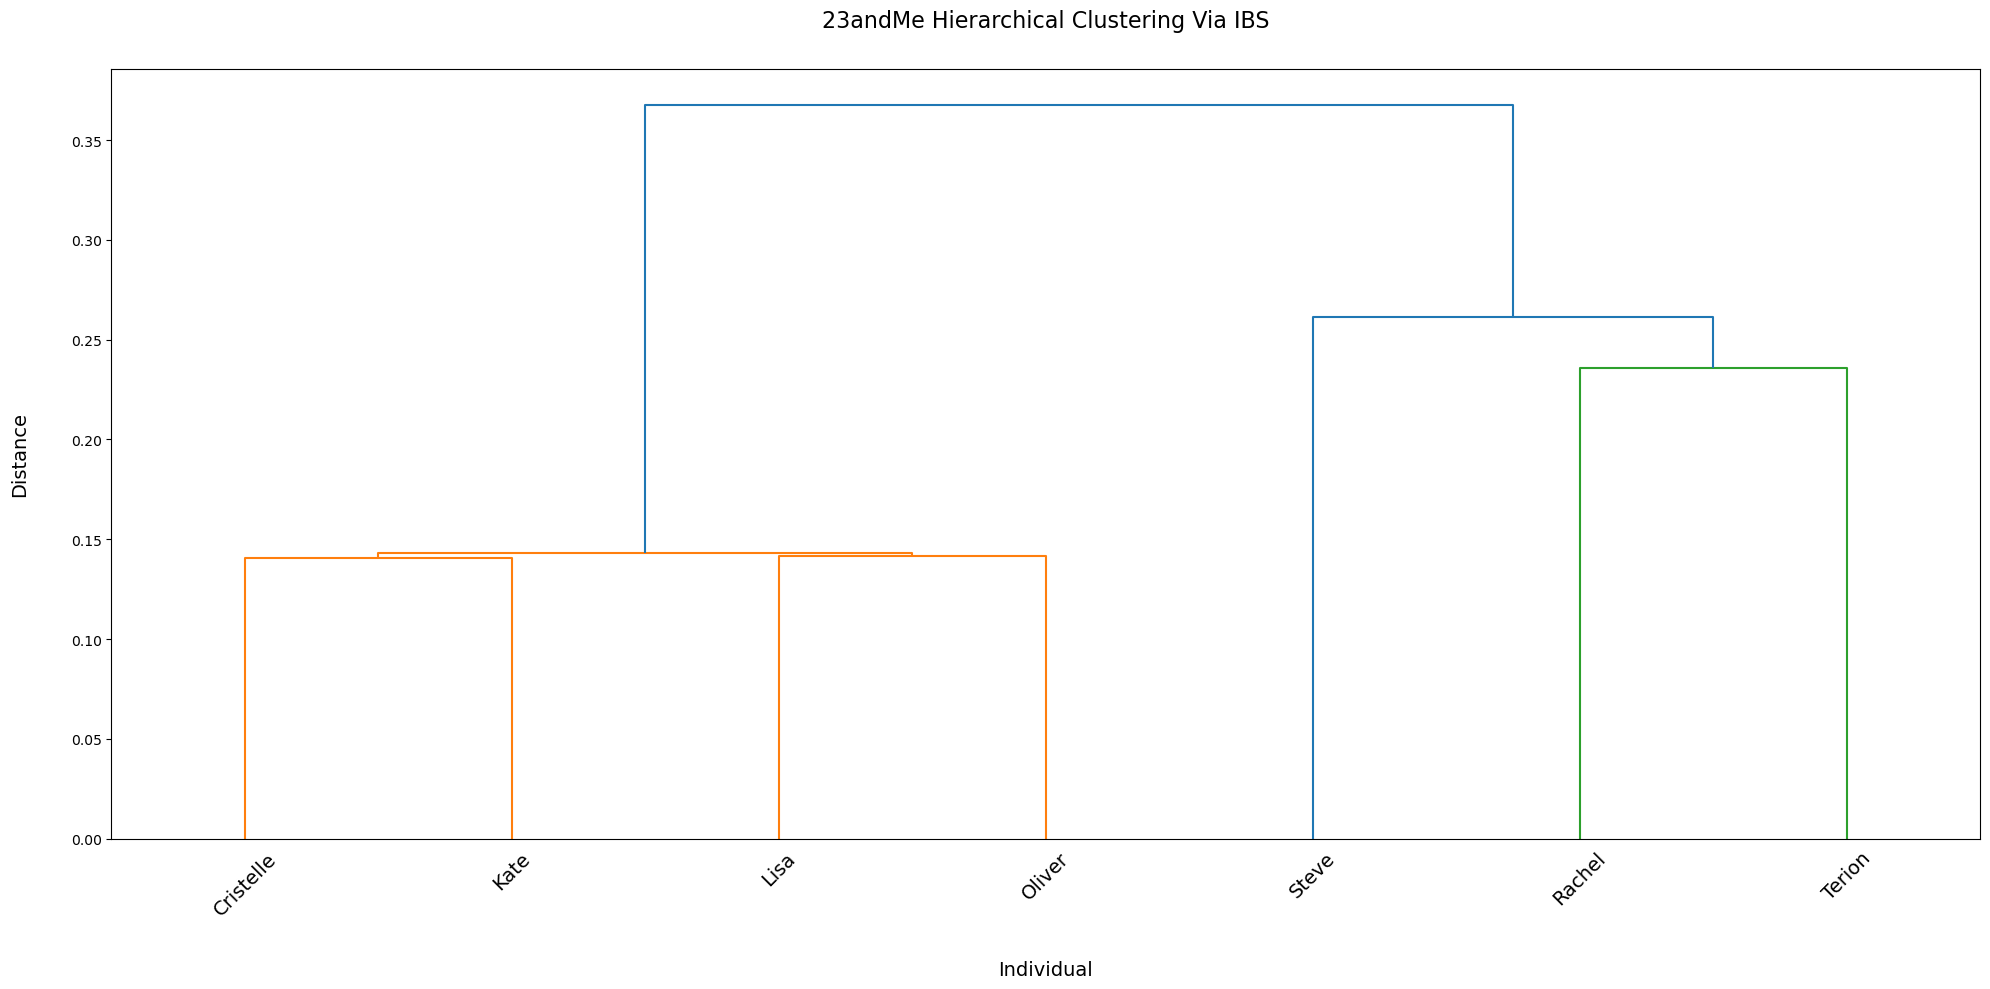

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
dendrogram(link, labels=names, leaf_rotation=45, leaf_font_size=14, ax=ax)

ax.set_title("23andMe Hierarchical Clustering Via IBS", fontsize=16, pad=30)
ax.set_xlabel("Individual", fontsize=14, labelpad=30)
ax.set_ylabel("Distance", fontsize=14, labelpad=30)

plt.tight_layout()
plt.show()

## Q5
**Dr. Salzberg is listed as a distant DNA relative of Dr. Karchin according to 23andMe. Assume that Cristelle, Kate, Lisa, Oliver, and Terion are not related to Dr. Karchin. Based on your IBS calculations from question 3 and the dendogram you made from question 4, do you see evidence for Dr. Karchin and Dr. Salzberg being related? Explain your answer.**

 > Based on the dendogram, Dr. Karchin and Dr. Salzberg are related because they are in the same cluster which suggests that they share a common ancestor. However, since the distance of ~0.25 between Dr. Karchin and Dr. Salzberg is greater than the distance of ~0.14 between the other individuals--Cristelle, Kate, Lisa, and Oliver--we can infer that Dr. Karchin and Dr. Salzberg are distance relatives. Terion is in the same cluster as Dr. Karchin and Dr. Salzberg because these individuals are the most dissimilar to the other 4 individuals: Cristelle, Kate, Lisa, and Oliver. This clustering doesn't imply that Terion is related to Dr. Karchin because the clustering is not based on relatedness, instead the clustering is based on dissimilarity compared to other groups.
---